In [1]:
from PIL import Image
import requests
import matplotlib.pyplot as plt
import numpy as np

# from DETR.datasets.coco import *
import torch
import torchvision.transforms as T
import os
import random
import cv2
import DETR.util.misc as utils
from DETR.models import build_model
from DETR.modules.ExplanationGenerator import Generator
import argparse

## Auxilary functions

In [2]:
class Namespace:
    def __init__(self, **kwargs):
        self.__dict__.update(kwargs)

In [3]:
# COCO classes
CLASSES = [
    'N/A', 'slc', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'slc',
    'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse',
    'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'interfering', 'backpack',
    'umbrella', 'N/A', 'N/A', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis',
    'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove',
    'skateboard', 'surfboard', 'tennis racket', 'bottle', 'N/A', 'wine glass',
    'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich',
    'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake',
    'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table', 'N/A',
    'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard',
    'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A',
    'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier',
    'toothbrush'
]

#i only use 2 classes 
CLASSES = [
    'slc', 'interfering', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'slc',
    'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse',
    'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'interfering', 'backpack',
    'umbrella', 'N/A', 'N/A', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis',
    'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove',
    'skateboard', 'surfboard', 'tennis racket', 'bottle', 'N/A', 'wine glass',
    'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich',
    'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake',
    'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table', 'N/A',
    'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard',
    'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A',
    'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier',
    'toothbrush'
]


# colors for visualization
COLORS = [[0.000, 0.447, 0.741], [0.850, 0.325, 0.098], [0.929, 0.694, 0.125],
          [0.494, 0.184, 0.556], [0.466, 0.674, 0.188], [0.301, 0.745, 0.933]]


# standard PyTorch mean-std input image normalization
transform = T.Compose([
    T.Resize(800),
    T.ToTensor(),
    T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# for output bounding box post-processing
def box_cxcywh_to_xyxy(x):
    x_c, y_c, w, h = x.unbind(1)
    b = [(x_c - 0.5 * w), (y_c - 0.5 * h),
         (x_c + 0.5 * w), (y_c + 0.5 * h)]
    return torch.stack(b, dim=1)

def rescale_bboxes(out_bbox, size):
    img_w, img_h = size
    b = box_cxcywh_to_xyxy(out_bbox)
    b = b * torch.tensor([img_w, img_h, img_w, img_h], dtype=torch.float32)
    return b

def plot_results(pil_img, prob, boxes):
    plt.figure(figsize=(16,10))
    plt.imshow(pil_img)
    ax = plt.gca()
    colors = COLORS * 100
    for p, (xmin, ymin, xmax, ymax), c in zip(prob, boxes.tolist(), colors):
        ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                   fill=False, color=c, linewidth=3))
        cl = p.argmax()
        text = f'{CLASSES[cl]}: {p[cl]:0.2f}'
        ax.text(xmin, ymin, text, fontsize=15,
                bbox=dict(facecolor='yellow', alpha=0.5))
    plt.axis('off')
    plt.show()


## Load the model

In [4]:
device = 'cuda'
args = Namespace(
    aux_loss = True,            
    backbone = 'resnet50',      
    batch_size = 4,             
    bbox_loss_coef = 5,         
    #clip_max_norm = 0.1,       
    coco_panoptic_path = None,  
    coco_path = None,           
    dataset_file = 'coco',      
    dec_layers = 6,             
    device = 'cuda:0' if torch.cuda.is_available() else 'cpu',
    #dice_loss_coef = 1,        
    dilation = False,           
    dim_feedforward = 2048,     
    #dist_url = 'env://',       
    #distributed = False,       
    dropout = 0.0,              
    enc_layers = 6,             
    eos_coef = 0.1,             
    #epochs = 20,               
    #eval = False,              
    #frozen_weights = None,     
    giou_loss_coef = 2,         
    hidden_dim = 256,           
    lr = 0.5e-5,                
    lr_backbone = 1e-5,         
    #lr_drop = None,            
    #mask_loss_coef = 1,        
    masks = False,              
    nheads = 8,                 
    num_queries = 100,          
    #num_workers = 12,          
    #output_dir = '',           
    position_embedding = 'sine',
    pre_norm = False,           
    #remove_difficult = False,  
    resume = 'https://dl.fbaipublicfiles.com/detr/detr-r50-e632da11.pth',
    #seed = 42,                 
    set_cost_bbox = 5,          
    set_cost_class = 1,         
    set_cost_giou = 2,          
    #start_epoch = 0,           
    weight_decay = 0.0001,      
    #world_size = 1             
)
model, criterion, postprocessors = build_model(args)
model.to(device)

checkpoint_name = "real_500_deterministic2"
checkpoint_path = f"DETR_checkpoints_paper/{checkpoint_name}.pth"


/home/dtr/.local/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/dtr/.local/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [5]:
checkpoint = torch.load(checkpoint_path, map_location='cpu', weights_only=True)

# list of transformation (from -> to)
transformations = [
    ('model.model.backbone', 'backbone'),
    ('conv_encoder', '0'),
    ('model.model', 'transformer'),
    ('encoder.layers.0.final_layer_norm', 'encoder.layers.0.norm2'),
    ('fc1', 'linear1'),
    ('fc2', 'linear2'),
    ('self_attn_layer_norm', 'norm1'),
    ('decoder.layers.0.final_layer_norm', 'decoder.layers.0.norm3'),
    ('encoder_attn_layer_norm', 'norm2'),
    ('encoder_attn', 'multihead_attn'),
    ('layernorm', 'norm'),
    ('transformer.query_position_embeddings.weight', 'query_embed.weight'),
    ('transformer.input_projection', 'input_proj'),
    ('model.bbox_predictor', 'bbox_embed'),
    ('model.class_labels_classifier', 'class_embed'),
    ('backbone.0.model','backbone.0.body'),
    ('transformer.encoder.layers.1.final_layer_norm','transformer.encoder.layers.1.norm2'),
    ('transformer.encoder.layers.2.final_layer_norm','transformer.encoder.layers.2.norm2'),
    ('transformer.encoder.layers.3.final_layer_norm','transformer.encoder.layers.3.norm2'),
    ('transformer.encoder.layers.4.final_layer_norm','transformer.encoder.layers.4.norm2'),
    ('transformer.encoder.layers.5.final_layer_norm','transformer.encoder.layers.5.norm2'),
    ('transformer.decoder.layers.1.final_layer_norm','transformer.decoder.layers.1.norm3'),
    ('transformer.decoder.layers.2.final_layer_norm','transformer.decoder.layers.2.norm3'),
    ('transformer.decoder.layers.3.final_layer_norm','transformer.decoder.layers.3.norm3'),
    ('transformer.decoder.layers.4.final_layer_norm','transformer.decoder.layers.4.norm3'),
    ('transformer.decoder.layers.5.final_layer_norm','transformer.decoder.layers.5.norm3')
]

# function to adjust the keys
def transform_key(k):
    for old, new in transformations:
        k = k.replace(old, new)
    return k

# adjust the keys of the whole state_dict
new_checkpoint = {transform_key(k): v for k, v in checkpoint.items()}

# show the adjusted keys
print(new_checkpoint.keys())

dict_keys(['backbone.0.body.conv1.weight', 'backbone.0.body.bn1.weight', 'backbone.0.body.bn1.bias', 'backbone.0.body.bn1.running_mean', 'backbone.0.body.bn1.running_var', 'backbone.0.body.layer1.0.conv1.weight', 'backbone.0.body.layer1.0.bn1.weight', 'backbone.0.body.layer1.0.bn1.bias', 'backbone.0.body.layer1.0.bn1.running_mean', 'backbone.0.body.layer1.0.bn1.running_var', 'backbone.0.body.layer1.0.conv2.weight', 'backbone.0.body.layer1.0.bn2.weight', 'backbone.0.body.layer1.0.bn2.bias', 'backbone.0.body.layer1.0.bn2.running_mean', 'backbone.0.body.layer1.0.bn2.running_var', 'backbone.0.body.layer1.0.conv3.weight', 'backbone.0.body.layer1.0.bn3.weight', 'backbone.0.body.layer1.0.bn3.bias', 'backbone.0.body.layer1.0.bn3.running_mean', 'backbone.0.body.layer1.0.bn3.running_var', 'backbone.0.body.layer1.0.downsample.0.weight', 'backbone.0.body.layer1.0.downsample.1.weight', 'backbone.0.body.layer1.0.downsample.1.bias', 'backbone.0.body.layer1.0.downsample.1.running_mean', 'backbone.0.bo

In [6]:

def load_and_transform_checkpoint(old_checkpoint):
    transformed_checkpoint = {}

    num_layers_encoder = 6  
    num_layers_decoder = 6 

    # transformation for the encoder
    for i in range(num_layers_encoder):
        base_key = f'transformer.encoder.layers.{i}.self_attn'
        # combine the Q, K, V weigths und bias
        combined_in_proj_weight = torch.cat([
            old_checkpoint.pop(f'{base_key}.q_proj.weight'),  # Q
            old_checkpoint.pop(f'{base_key}.k_proj.weight'),  # K
            old_checkpoint.pop(f'{base_key}.v_proj.weight')   # V
        ], dim=0)
        combined_in_proj_bias = torch.cat([
            old_checkpoint.pop(f'{base_key}.q_proj.bias'),  # Q
            old_checkpoint.pop(f'{base_key}.k_proj.bias'),  # K
            old_checkpoint.pop(f'{base_key}.v_proj.bias')   # V
        ])
        transformed_checkpoint[f'{base_key}.in_proj_weight'] = combined_in_proj_weight
        transformed_checkpoint[f'{base_key}.in_proj_bias'] = combined_in_proj_bias

    # transformation for the decoder
    for i in range(num_layers_decoder):
        base_key = f'transformer.decoder.layers.{i}.self_attn'
        # combine the Q, K, V weigths und bias
        combined_in_proj_weight = torch.cat([
            old_checkpoint.pop(f'{base_key}.q_proj.weight'),  # Q
            old_checkpoint.pop(f'{base_key}.k_proj.weight'),  # K
            old_checkpoint.pop(f'{base_key}.v_proj.weight')   # V
        ], dim=0)
        combined_in_proj_bias = torch.cat([
            old_checkpoint.pop(f'{base_key}.q_proj.bias'),  # Q
            old_checkpoint.pop(f'{base_key}.k_proj.bias'),  # K
            old_checkpoint.pop(f'{base_key}.v_proj.bias')   # V
        ])
        transformed_checkpoint[f'{base_key}.in_proj_weight'] = combined_in_proj_weight
        transformed_checkpoint[f'{base_key}.in_proj_bias'] = combined_in_proj_bias

    # transformation for the multihead_attn
    for i in range(num_layers_decoder):
        base_key = f'transformer.decoder.layers.{i}.multihead_attn'
        # combine the Q, K, V weigths und bias
        combined_in_proj_weight = torch.cat([
            old_checkpoint.pop(f'{base_key}.q_proj.weight'),  # Q
            old_checkpoint.pop(f'{base_key}.k_proj.weight'),  # K
            old_checkpoint.pop(f'{base_key}.v_proj.weight')   # V
        ], dim=0)
        combined_in_proj_bias = torch.cat([
            old_checkpoint.pop(f'{base_key}.q_proj.bias'),  # Q
            old_checkpoint.pop(f'{base_key}.k_proj.bias'),  # K
            old_checkpoint.pop(f'{base_key}.v_proj.bias')   # V
        ])
        transformed_checkpoint[f'{base_key}.in_proj_weight'] = combined_in_proj_weight
        transformed_checkpoint[f'{base_key}.in_proj_bias'] = combined_in_proj_bias

    # update the changed keys
    transformed_checkpoint.update(old_checkpoint)

    return transformed_checkpoint

In [7]:
transformed_checkpoint = load_and_transform_checkpoint(new_checkpoint)
print(transformed_checkpoint.keys())

dict_keys(['transformer.encoder.layers.0.self_attn.in_proj_weight', 'transformer.encoder.layers.0.self_attn.in_proj_bias', 'transformer.encoder.layers.1.self_attn.in_proj_weight', 'transformer.encoder.layers.1.self_attn.in_proj_bias', 'transformer.encoder.layers.2.self_attn.in_proj_weight', 'transformer.encoder.layers.2.self_attn.in_proj_bias', 'transformer.encoder.layers.3.self_attn.in_proj_weight', 'transformer.encoder.layers.3.self_attn.in_proj_bias', 'transformer.encoder.layers.4.self_attn.in_proj_weight', 'transformer.encoder.layers.4.self_attn.in_proj_bias', 'transformer.encoder.layers.5.self_attn.in_proj_weight', 'transformer.encoder.layers.5.self_attn.in_proj_bias', 'transformer.decoder.layers.0.self_attn.in_proj_weight', 'transformer.decoder.layers.0.self_attn.in_proj_bias', 'transformer.decoder.layers.1.self_attn.in_proj_weight', 'transformer.decoder.layers.1.self_attn.in_proj_bias', 'transformer.decoder.layers.2.self_attn.in_proj_weight', 'transformer.decoder.layers.2.self_a

In [8]:
model.load_state_dict(transformed_checkpoint, strict=False)

_IncompatibleKeys(missing_keys=[], unexpected_keys=['transformer.encoder.layers.0.self_attn.in_proj_weight', 'transformer.encoder.layers.0.self_attn.in_proj_bias', 'transformer.encoder.layers.1.self_attn.in_proj_weight', 'transformer.encoder.layers.1.self_attn.in_proj_bias', 'transformer.encoder.layers.2.self_attn.in_proj_weight', 'transformer.encoder.layers.2.self_attn.in_proj_bias', 'transformer.encoder.layers.3.self_attn.in_proj_weight', 'transformer.encoder.layers.3.self_attn.in_proj_bias', 'transformer.encoder.layers.4.self_attn.in_proj_weight', 'transformer.encoder.layers.4.self_attn.in_proj_bias', 'transformer.encoder.layers.5.self_attn.in_proj_weight', 'transformer.encoder.layers.5.self_attn.in_proj_bias', 'transformer.decoder.layers.0.self_attn.in_proj_weight', 'transformer.decoder.layers.0.self_attn.in_proj_bias', 'transformer.decoder.layers.0.multihead_attn.in_proj_weight', 'transformer.decoder.layers.0.multihead_attn.in_proj_bias', 'transformer.decoder.layers.1.self_attn.in

# Evaluation

Define the parameters

In [9]:
threshold_area_factor = 16

In [10]:
gen = Generator(model)

In [11]:
def detect_red_areas(mask, bbox_area):
    contours, _ = cv2.findContours(mask.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    lower_threshold_area = bbox_area / 128
    filtered_contours = []

    # Filter contours based on the lower threshold
    for contour in contours:
        if cv2.contourArea(contour) >= lower_threshold_area:
            filtered_contours.append(contour)

    if not filtered_contours:
        return contours
    return filtered_contours

In [12]:
def model_evaluation(model, img, device, confidence_threshold=0.8):
    mode_outputs = model(img)
    probabilities = mode_outputs['pred_logits'].softmax(-1)[0, :, :-1]
    keep_probabilities = probabilities.max(-1).values > confidence_threshold

    if keep_probabilities.nonzero().shape[0] < 1:
        return None, None

    mode_outputs['pred_boxes'] = mode_outputs['pred_boxes'].cpu()
    keep_probabilities = keep_probabilities.to(mode_outputs['pred_boxes'].device)
    return mode_outputs, keep_probabilities

In [13]:
def attention_calculation(model, im, img, outputs, keep):
    # convert boxes from [0; 1] to image scales
    bboxes_scaled = rescale_bboxes(outputs['pred_boxes'][0, keep], im.size)

    # use lists to store the outputs via up-values
    conv_features, enc_attn_weights, dec_attn_weights = [], [], []

    hooks = [
        model.backbone[-2].register_forward_hook(
            lambda self, input, output: conv_features.append(output)
        ),
        # model.transformer.encoder.layers[-1].self_attn.register_forward_hook(
        #     lambda self, input, output: enc_attn_weights.append(output[1])
        # ),
        model.transformer.decoder.layers[-1].multihead_attn.register_forward_hook(
            lambda self, input, output: dec_attn_weights.append(output[1])
        ),
    ]

    for layer in model.transformer.encoder.layers:
        hook = layer.self_attn.register_forward_hook(
            lambda self, input, output: enc_attn_weights.append(output[1])
        )
        hooks.append(hook)

    model(img)

    for hook in hooks:
        hook.remove()

    # don't need the list anymore
    conv_features = conv_features[0]
    enc_attn_weights = enc_attn_weights[-1]
    dec_attn_weights = dec_attn_weights[0]

    # get the feature map shape
    h, w = conv_features['0'].tensors.shape[-2:]
    
    return bboxes_scaled,h,w

In [14]:
def generate_attention_mask_for_visualization(img_np, cam, h, w):  
    
    cam = (cam - cam.min()) / (cam.max() - cam.min())
    cam_image = cam.view(h, w).data.cpu().numpy()

    # scale cam_image on the size of im
    h_im, w_im, _ = img_np.shape
    cam_scaled = cv2.resize(cam_image, (w_im, h_im), interpolation=cv2.INTER_LINEAR)

    # define threshold and mask
    threshold = 0.4
    mask = cam_scaled > threshold

    # use the colour map for the scaled cam image where the mask is true
    rgba_image = np.zeros((h_im, w_im, 4))
    rgba_image[..., 0] = 1 and mask.astype(float)
    rgba_image[..., 1] = 0
    rgba_image[..., 2] = 0

    return rgba_image, mask

In [15]:
def generate_attention_mask(img_np, cam, h, w):  
    
    cam = (cam - cam.min()) / (cam.max() - cam.min())
    cam_image = cam.view(h, w).data.cpu().numpy()

    # scale cam_image on the size of im
    h_im, w_im, _ = img_np.shape
    cam_scaled = cv2.resize(cam_image, (w_im, h_im), interpolation=cv2.INTER_LINEAR)

    # define threshold and mask
    threshold = 0.4
    mask = cam_scaled > threshold
    
    return mask

In [16]:
def calculate_iou(x1, y1, w1, h1 , x3, y3, w2, h2):

    x2 = x1 + w1    
    y2 = y1 + h1    

    x4 = x3 + w2
    y4 = y3 + h2

    # Calculation of the intersection rectangle coordinates
    if (x2 < x3) | (x4 < x1):
        return 0  # no overlap
    
    if (y2 < y3) | (y4 < y1):
        return 0  # no overlap

    # Calculation of the areas of both bounding boxes and the section
    area_box1 = w1 * h1 
    area_box2 = w2 * h2 

    # Calculate the intersection area
    area_intersection = max(0, min(x2, x4) - max(x1, x3)) * max(0, min(y2, y4) - max(y1, y3))

    # Calculate the Intersection over Union (IoU)
    iou = area_intersection / (area_box1 + area_box2 - area_intersection)
    return iou

In [17]:
import json
def load_ground_truth_boxes(json_file, filename):
    with open(json_file, 'r') as f:
        data = json.load(f)

    # append all ground truth data of the file
    ground_truth_boxes = []
    for image in data['images']:
        if image['file_name'] == filename:
            image_id = image['id']
            for annotation in data['annotations']:
                if annotation['image_id'] == image_id:
                    xmin = annotation['bbox'][0]
                    ymin = annotation['bbox'][1]
                    xmax = xmin + annotation['bbox'][2]
                    ymax = ymin + annotation['bbox'][3]
                    ground_truth_boxes.append((xmin, ymin, xmax, ymax))
            break  

    return ground_truth_boxes

## Evaluation function 

 To determine
 all possible combinations for selecting features for occlusion
 from distinct features in an image, a Cartesian product is
 employed. A list of binary combinations is generated using
 integer values (0 and 1), where each combination represents
 a unique selection of features. This is achieved by generating
 all possible sequences of length n (where n is the number of
 features), with 0 indicating that a feature is occluded and 1
 indicating that a feature remains visible. Subsequently, each
 occlusion combination is applied to the image, and the mod
ified image undergoes prediction to detect the object. If the
 object remains identifiable, the newly identified features are
 compared to the original features to observe any variations.
 This systematic approach is replicated for each image within
 the test dataset.

In [18]:
from itertools import product
def evaluate(model, gen, im, device, filename = None, json_file='test_video/_annotations.coco.json'):
    Visualization = True # set if you want to see the method
    global total_success_count, total_valid_combinations
    img = transform(im).unsqueeze(0).to(device)

    outputs, keep = model_evaluation(model, img, device)    
    
    if outputs is None:
        return [],[], 0, []
    
    probas = outputs['pred_logits'].softmax(-1)[0, :, :-1]     
    bboxes_scaled, cam_h, cam_w = attention_calculation(model, im, img, outputs, keep)
    img_np = np.array(im).astype(float)

    if (filename !=None):
        ground_truth_boxes = load_ground_truth_boxes(json_file, filename)
           
    unchanged_features = []
    combination_results = []
    features_after_occlusion = 0

    detection_without_occlusion_results = []

    for idx, (xmin, ymin, xmax, ymax) in zip(keep.nonzero(), bboxes_scaled):

        contours_info = []        
        iou_gt_bbox_max = 0.8

        # safe gt box for the comparison with the occluded slc
        gtbox_x = 0
        gtbox_y = 0
        gtbox_w = 0
        gtbox_h = 0
        gtbox_index_max = None
        gtbox_area = 0

        bboxes_scaled_w = xmax - xmin
        bboxes_scaled_h = ymax - ymin
        for index, (gt_xmin, gt_ymin, gt_xmax, gt_ymax) in enumerate(ground_truth_boxes):
            iou_gt_bbox = calculate_iou(xmin, ymin, bboxes_scaled_w , bboxes_scaled_h , gt_xmin, gt_ymin, gt_xmax - gt_xmin, gt_ymax - gt_ymin)
            if(iou_gt_bbox > iou_gt_bbox_max):
                iou_gt_bbox_max = iou_gt_bbox
                gtbox_x = gt_xmin
                gtbox_y = gt_ymin
                gtbox_w = gt_xmax - gt_xmin
                gtbox_h = gt_ymax - gt_ymin
                gtbox_index_max = int(index)
                gtbox_area = int(gtbox_w) * int(gtbox_h)

        if gtbox_index_max is not None:
            del ground_truth_boxes[gtbox_index_max]

        if CLASSES[probas[idx].argmax()] == 'slc' and iou_gt_bbox_max > 0.8:
            cam = gen.generate_ours(img, idx, use_lrp=False)
            mask = generate_attention_mask(img_np, cam, cam_h, cam_w)

            # detect red areas and get their contours
            contours = detect_red_areas(mask, gtbox_area)

            threshold_area = gtbox_area / threshold_area_factor
            
            center_bboxes_scaled_x = xmin  + int(bboxes_scaled_w) / 2
            center_bboxes_scaled_y = ymin + int(bboxes_scaled_h) / 2

            if Visualization == True:
                img_np_uint8 = np.array(im).astype(np.uint8)          
                cv2.rectangle(img_np_uint8,(int(xmin),int(ymin)),(int(xmin)+int(bboxes_scaled_w),int(ymin)+int(bboxes_scaled_h)),(0,0,255),2)

            high_attention_area = 0    
            for i, contour in enumerate(contours):
                area = cv2.contourArea(contour)
                high_attention_area += area  
                x, y, w, h = cv2.boundingRect(contour)  
            
                size_label = "big" if area > threshold_area else "small"

                # Determine which quadrants the contour occupies
                quadrants = []
                if y < center_bboxes_scaled_y:
                    if x < center_bboxes_scaled_x:
                        quadrants.append("1")                       # Quadrant 2 (Top-Left)
                    if x > center_bboxes_scaled_x or x + w > center_bboxes_scaled_x:
                        quadrants.append("2")                       # Quadrant 1 (Top-Right)
                if y > center_bboxes_scaled_y or y + h > center_bboxes_scaled_y:
                    if x < center_bboxes_scaled_x:
                        quadrants.append("3")                       # Quadrant 3 (Bottom-Left)
                    if x > center_bboxes_scaled_x or x + w > center_bboxes_scaled_x:
                        quadrants.append("4")                       # Quadrant 4 (Bottom-Right)                

                contour_info = {
                    "contour": contour,
                    "area": area,
                    "size_label": size_label + str(i),
                    "bbox": (x, y, w, h),
                    "area_relative_to_gtbox":area/gtbox_area,
                    "quadrants": quadrants
                }
                contours_info.append(contour_info)                

                if Visualization == True:
                    cv2.rectangle(img_np_uint8,(x,y),(x+w,y+h),(0,255,0),2)

            unique_quadrants = set() 
            unique_quadrants = {quadrant for info in contours_info for quadrant in info['quadrants']}   
            
            all_combinations = list(product([0, 1], repeat=len(contours)))
            valid_combinations = [comb for comb in all_combinations if sum(comb) > 0]
            
            if len(contours) > 0:
                combination_max_occlusion = valid_combinations[-1]  
                combination_sequence = []
                
                for i in range(len(combination_max_occlusion)):
                    combination_sequence.append(contours_info[i]['size_label'])

                # combine the sequence to a string
                combination_sequence_string = " ".join(combination_sequence)    

                detection_without_occlusion_results.append(((filename + "bbox" + str(gtbox_index_max)), combination_sequence_string, high_attention_area/gtbox_area, sorted(unique_quadrants)))

                combination_results = []

                # for visualization
                if Visualization == True:
                    n_combinations = len(valid_combinations)
                    n_cols = 5 
                    n_rows = (n_combinations // n_cols) + (n_combinations % n_cols > 0)

                    fig, axs = plt.subplots(n_rows, n_cols + 1, figsize=(5 * (n_cols + 1), 5 * n_rows))
                    axs = axs.flatten()

                    axs[0].imshow(img_np_uint8)
                    axs[0].set_title("Original Image")
                    axs[0].axis('off')
                # for visualization ends

                for i, combination in enumerate(valid_combinations):   
                    img_np_comb = img_np.copy()       
                    occluded_info = []
                    visible_info = []

                    for j, (contour_info, is_occluded) in enumerate(zip(contours_info, combination)):
                        if is_occluded:
                            # Draw and fill the contour to indicate occlusion
                            cv2.drawContours(img_np_comb, [contour_info['contour']], -1, (0, 0, 0), thickness=cv2.FILLED)
                            occluded_info.append(contour_info)
                        else:
                            visible_info.append(contour_info)

                    combination_key = tuple(ci['size_label'] for ci in occluded_info)     
                    occluded_area_relative_to_gtbox = sum(info['area_relative_to_gtbox'] for info in occluded_info)

                    unique_quadrants = set()
                    unique_quadrants = {quadrant for info in visible_info for quadrant in info['quadrants']}    

                    img_np_uint8_comb = (img_np_comb * 255 / img_np_comb.max()).astype(np.uint8)

                    # visualize the masked image
                    if Visualization == True:
                        axs[i+1].imshow(img_np_uint8_comb)
                        axs[i+1].set_title(f"Combination {i + 1}")
                        axs[i+1].axis('off')
                    #end of visualize
                    
                    im_restored = Image.fromarray(img_np_uint8_comb)
                    img_tensor_comb = transform(im_restored).unsqueeze(0).to(device)

                    new_outputs = []
                    new_keep = []

                    new_outputs, new_keep = model_evaluation(model, img_tensor_comb, device, 0.8)
                    new_img = transform(im_restored).unsqueeze(0).to(device)

                    if new_outputs is not None and new_keep is not None:

                        new_probas = new_outputs['pred_logits'].softmax(-1)[0, :, :-1]                      
                        occlusion_bboxes_scaled, h2, w2 = attention_calculation(model, im_restored, new_img, new_outputs, new_keep)       
                        
                        max_iou_occluded_slc_found = 0
                        occlussion_cam = None

                        for occlusion_idx, (xmin2, ymin2, xmax2, ymax2) in zip(new_keep.nonzero(), occlusion_bboxes_scaled):
                            if CLASSES[new_probas[occlusion_idx].argmax()] == 'slc':
                                bbox_slc_occluded_w = xmax2-xmin2
                                bbox_slc_occluded_h = ymax2-ymin2
                                iou_bbox = calculate_iou(gtbox_x, gtbox_y, gtbox_w, gtbox_h, xmin2, ymin2, bbox_slc_occluded_w, bbox_slc_occluded_h)
                                if (iou_bbox > max_iou_occluded_slc_found):
                                    max_iou_occluded_slc_found = iou_bbox
                                    occlussion_cam = None
                                    occlussion_cam = gen.generate_ours(new_img, occlusion_idx, use_lrp=False)

                        if max_iou_occluded_slc_found > 0.8: # slc is the same detected

                            occlusion_mask = generate_attention_mask(img_np_comb, occlussion_cam, h2, w2)
                            high_attention_area_occluded_slc = 0  
                            # detect red areas and generate mask
                            occlusion_contours = detect_red_areas(occlusion_mask, gtbox_area)
                            for i, contour in enumerate(occlusion_contours):
                                area = cv2.contourArea(contour)
                                high_attention_area_occluded_slc += area
                                x, y, w, h = cv2.boundingRect(contour)

                                for j in range(len(visible_info)):
                                    bbox_x,bbox_y,bbox_w,bbox_h = visible_info[j]["bbox"]
                                    iou = calculate_iou(x, y, w, h, bbox_x, bbox_y, bbox_w, bbox_h)
                                    if iou > 0.8:
                                        label  = visible_info[j]["size_label"]
                                        unchanged_feature = {
                                                    "feature_name": label,
                                                    "area_new": area,
                                                    "area_old": visible_info[j]["area"],                                            
                                                    "bbox_new": (x, y, w, h),
                                                    "bbox_old": (bbox_x,bbox_y,bbox_w,bbox_h) 
                                                }
                                        unchanged_features.append(unchanged_feature)

                            features_after_occlusion += (len(visible_info))
                            combination_results.append(((filename + "bbox" + str(gtbox_index_max)),combination_sequence_string, 'True', combination_key, high_attention_area/gtbox_area, occluded_area_relative_to_gtbox, high_attention_area_occluded_slc/gtbox_area, sorted(unique_quadrants)))   

                        else:
                            combination_results.append(((filename + "bbox" + str(gtbox_index_max)),combination_sequence_string, 'False', combination_key, high_attention_area/gtbox_area, occluded_area_relative_to_gtbox, 0, sorted(unique_quadrants)))
                            if features_after_occlusion is None:
                                features_after_occlusion = 0
                    else:
                        combination_results.append(((filename + "bbox" + str(gtbox_index_max)),combination_sequence_string, 'False', combination_key, high_attention_area/gtbox_area, occluded_area_relative_to_gtbox, 0, sorted(unique_quadrants)))
                        if features_after_occlusion is None:
                            features_after_occlusion = 0
                if Visualization == True:
                    for ax in axs[len(valid_combinations) + 1:]:
                        ax.axis('off')  # deactivate empty subplots
                        plt.tight_layout()
                        plt.show()
        else:
            print("no slc prediction without occlusion")

    
    changed_features = features_after_occlusion - len(unchanged_features)
    
    if not combination_results and not unchanged_features and not changed_features:
        print("Warning: No results.")  
        return [], [], 0, detection_without_occlusion_results
    
    elif not combination_results:
        print("Warning: No combination results found.")
        return [], [], 0, detection_without_occlusion_results
    
    elif not unchanged_features and not changed_features:
        print("Warning: No unchanged or changed features found.")  
        print(f"combination results: {combination_results}")
        return combination_results, [], 0, detection_without_occlusion_results

    elif not unchanged_features:
        print("Warning: No unchanged features found.")
        return combination_results, [], changed_features, detection_without_occlusion_results

    elif not changed_features:
        print("Warning: No changed features found.")
        return combination_results, unchanged_features, 0, detection_without_occlusion_results
    else:
        return combination_results, unchanged_features, changed_features, detection_without_occlusion_results

## Test the evaluation script

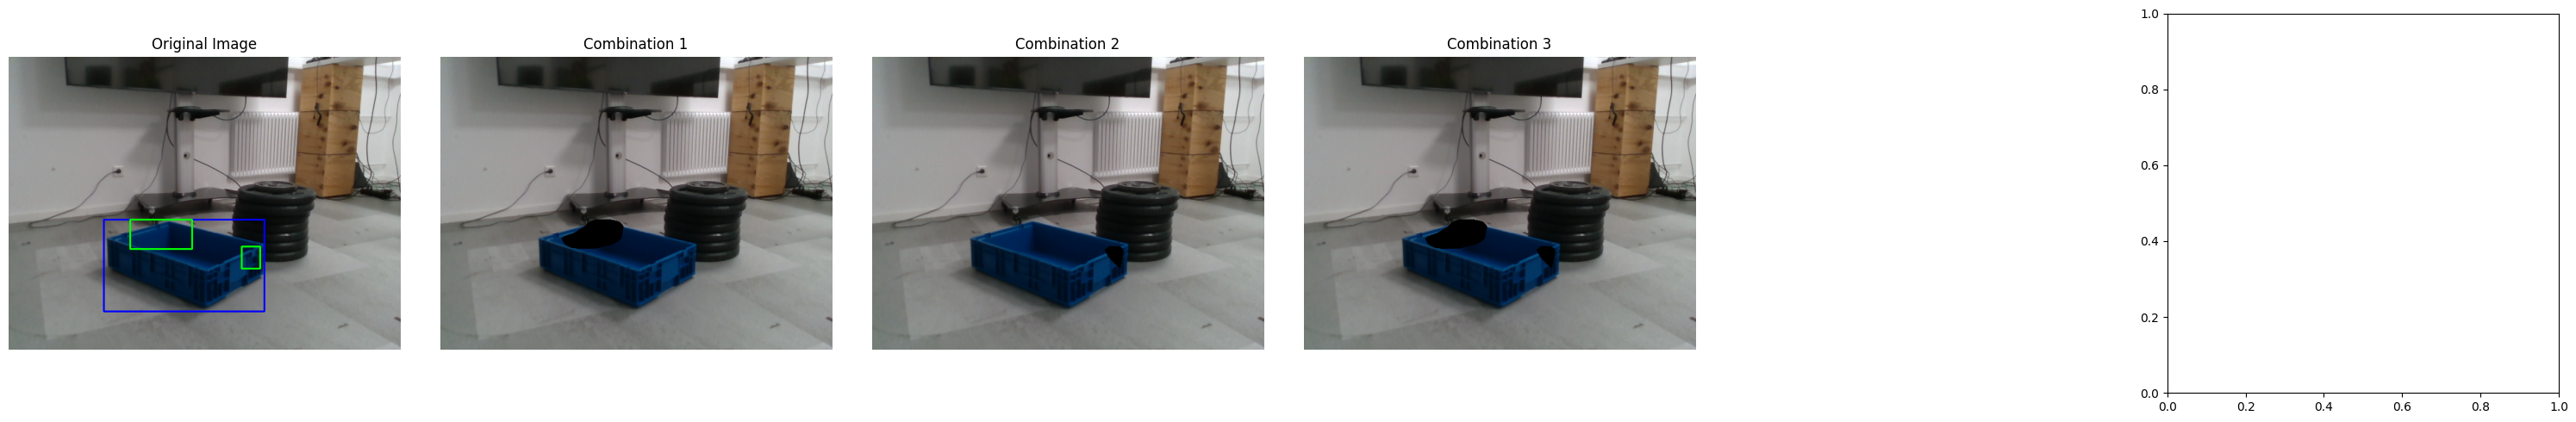

<Figure size 640x480 with 0 Axes>

([('frame000462_rgb.pngbbox0',
   'small0 big1',
   'True',
   ('big1',),
   0.10908615757042253,
   0.09130171654929578,
   0.012585277288732395,
   ['2', '4']),
  ('frame000462_rgb.pngbbox0',
   'small0 big1',
   'True',
   ('small0',),
   0.10908615757042253,
   0.01778444102112676,
   0.08198998679577464,
   ['1', '2']),
  ('frame000462_rgb.pngbbox0',
   'small0 big1',
   'True',
   ('small0', 'big1'),
   0.10908615757042253,
   0.10908615757042255,
   0.012819102112676057,
   [])],
 [{'feature_name': 'big1',
   'area_new': 2980.5,
   'area_old': 3319.0,
   'bbox_new': (203, 267, 95, 47),
   'bbox_old': (198, 267, 101, 48)}],
 1,
 [('frame000462_rgb.pngbbox0',
   'small0 big1',
   0.10908615757042253,
   ['1', '2', '4'])])

In [19]:
filename = "frame000462_rgb.png"
folder = 'test_video/'
filepath = os.path.join(folder, filename)
im = Image.open(filepath)

evaluate(model, gen, im, 'cuda',filename)

# Evalute the test directory

In [20]:
results_folder = "results_comparison_paper"

In [21]:
def write_results_to_text_file(combination_results, model_name):
    with open(f'{results_folder}/results_comparison_{model_name}.txt', mode='w', newline='') as file:        
        for result in combination_results:
            if isinstance(result, list) and all(isinstance(item, tuple) for item in result):
                for item in result:
                    filename, combination_sequence, success, combination, high_attention_area_without_occlussion_slc, area_occluded_relative_to_gtbox, high_attention_area_occluded_slc, quadrants  = item
                    combination_str = ' '.join(map(str, combination))
                    file.write(f"filename: {filename}\tsequence: {combination_sequence}\tsuccess: {success}\tcombination: {combination_str}\thigh_attention_area_without_occlussion_slc: {high_attention_area_without_occlussion_slc}\tarea_occluded_relative_to_gtbox: {area_occluded_relative_to_gtbox}\thigh_attention_area_occluded_slc: {high_attention_area_occluded_slc}\tquadrants: {quadrants}\n")
            elif isinstance(result, tuple) and len(result) == 2:
                combination, success = result
                combination_str = '\t'.join(map(str, combination))
                file.write(f"{success}\t{combination_str}\n")
            else:
                print(f"Invalid data format comparison: {result}")


In [22]:
def write_results_without_occlusion_to_text_file(combination_results, model_name):
    with open(f'{results_folder}/results_comparison_{model_name}_without_occlusion.txt', mode='w', newline='') as file:        
        for result in combination_results:
            if isinstance(result, list) and all(isinstance(item, tuple) for item in result):
                for item in result:
                    filename, combination_sequence_string, area_relative_to_gtbox, quadrants  = item
                    file.write(f"filename: {filename}\tcombination_sequence_string: {combination_sequence_string}\thigh_attention_area_relative_to_gtbox: {area_relative_to_gtbox}\tquadrants: {quadrants}\n")
            else:
                print(f"Invalid data format comparison without occlusion: {result}")

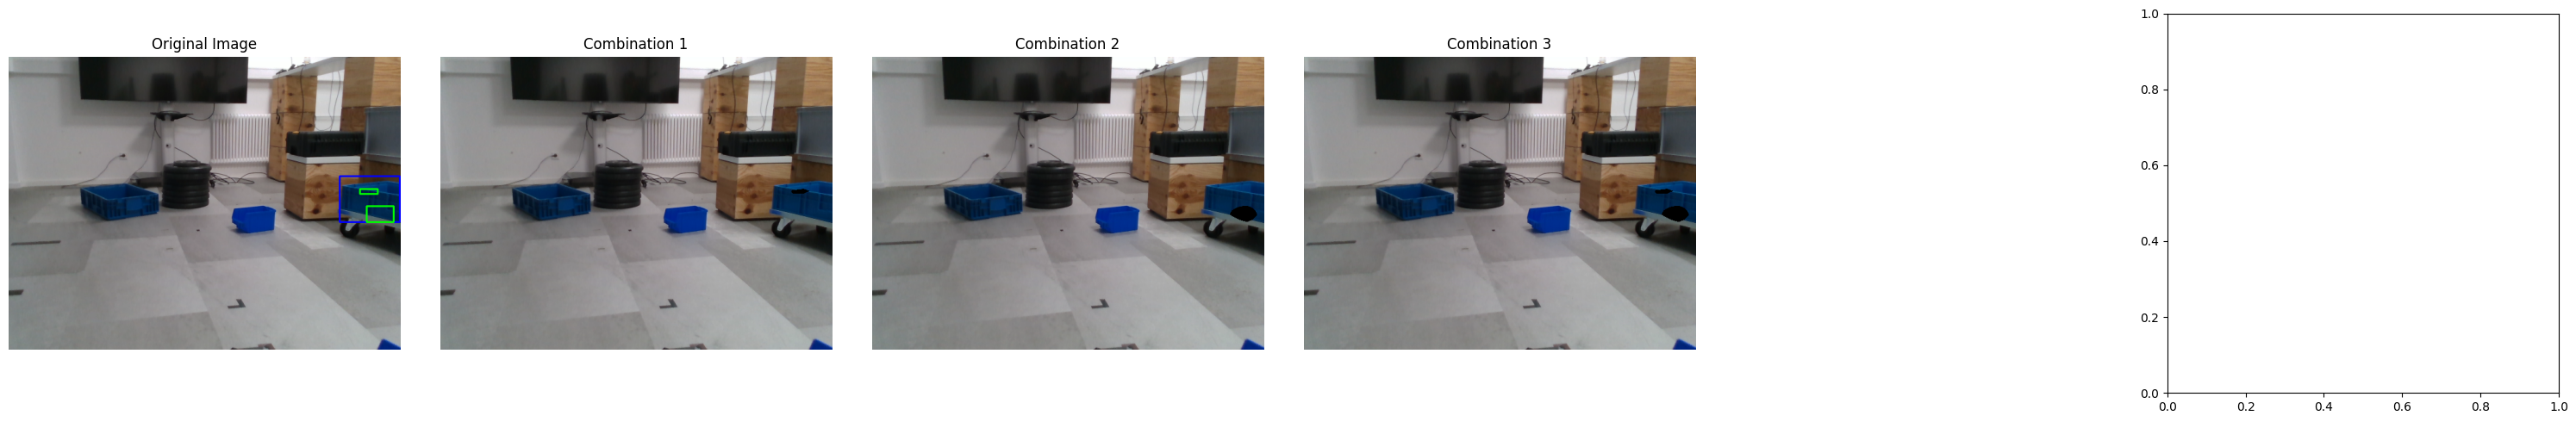

<Figure size 640x480 with 0 Axes>

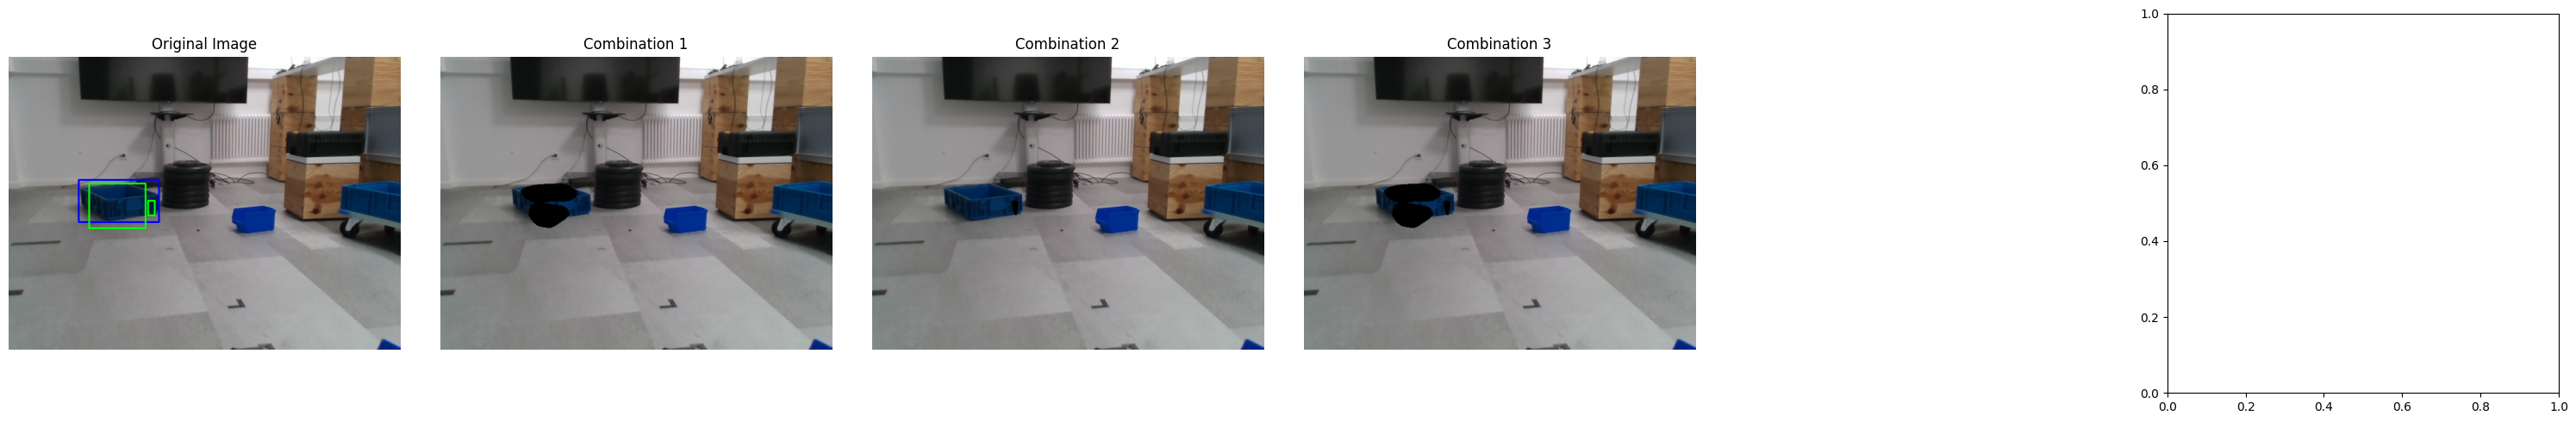

<Figure size 640x480 with 0 Axes>

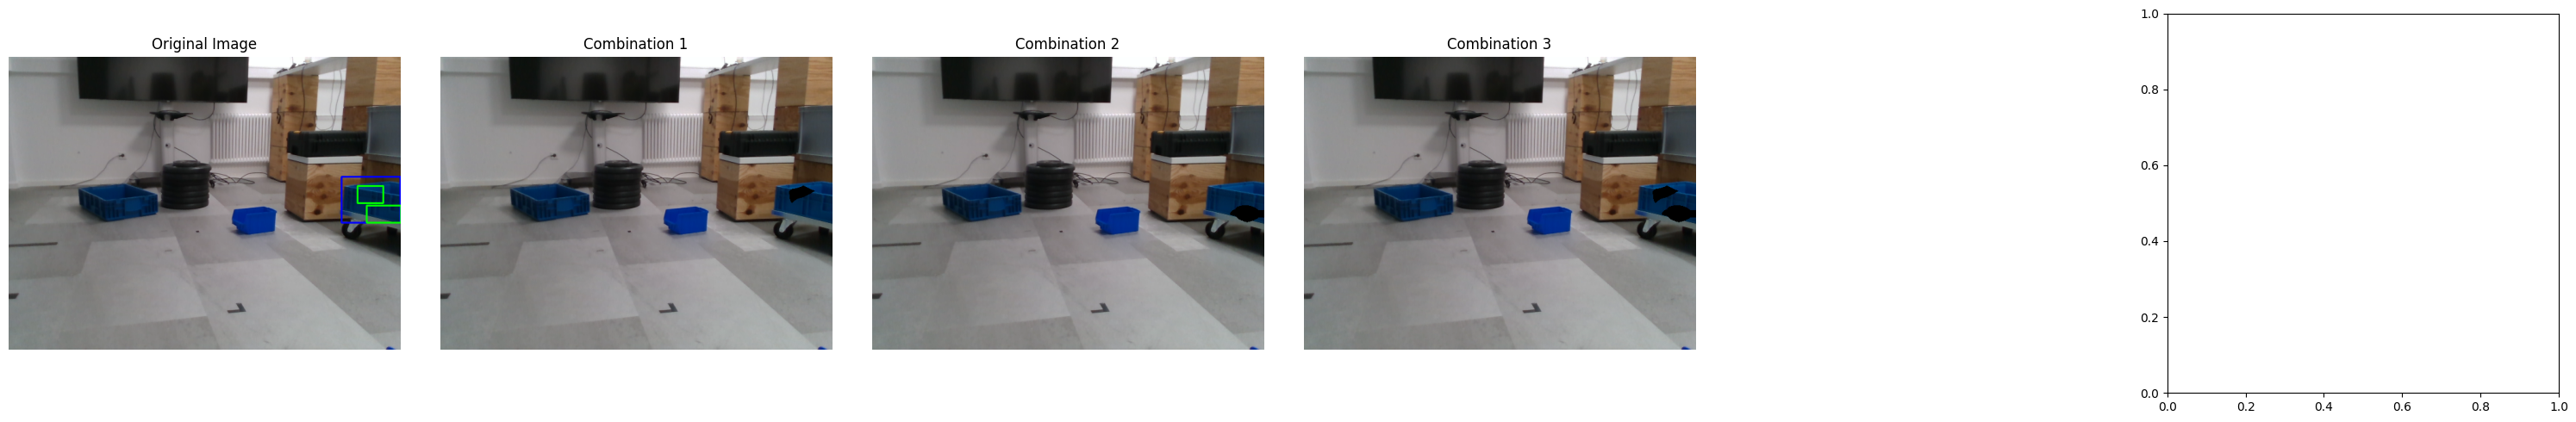

<Figure size 640x480 with 0 Axes>

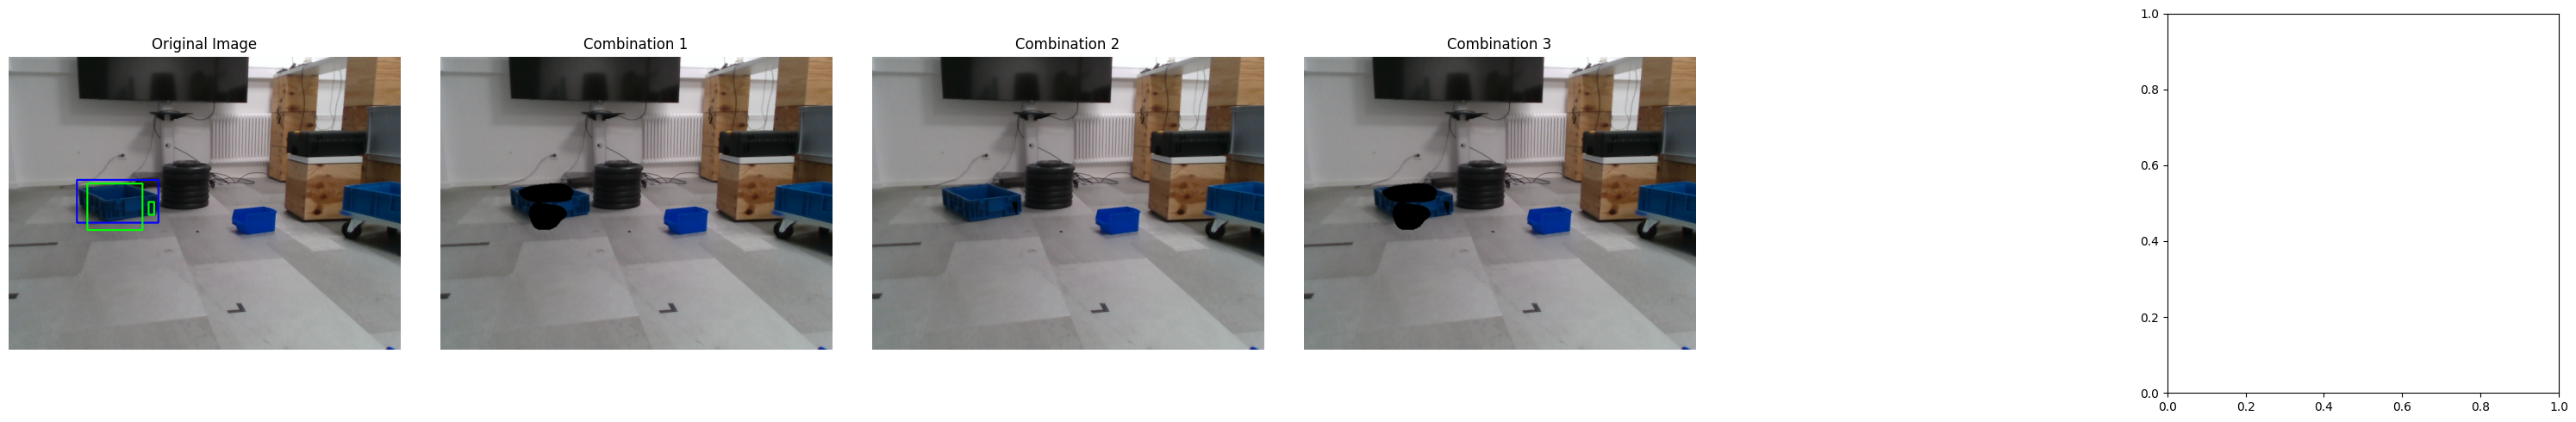

<Figure size 640x480 with 0 Axes>

KeyboardInterrupt: 

In [23]:
import os
from PIL import Image
import torch

combination_results_ = []
unchanged_features_results_ = []
detection_without_occlusion_results_ = []

def evaluate_directory(model, generator, directory, device):
    filenames = [f for f in os.listdir(directory) if f.endswith('.png')]
    changed_features_ = 0
    for filename in filenames:
        filepath = os.path.join(directory, filename)
        image = Image.open(filepath)  

        combination_results, unchanged_features_results, changed_features, detection_without_occlusion_results = evaluate(model, generator, image, 'cuda',filename, "test_video/_annotations.coco.json")        
        changed_features_ += changed_features
        combination_results_.append(combination_results)
        unchanged_features_results_.append(unchanged_features_results)
        detection_without_occlusion_results_.append(detection_without_occlusion_results)
        
        
    return changed_features_    

folder = 'test_video/'

changed_features_ = evaluate_directory(model, gen, folder, 'cuda')
total_unchanged_features = sum(len(features) for features in unchanged_features_results_)
print(f"unchanged_features: {total_unchanged_features}, changed_features: {changed_features_}")
write_results_to_text_file(combination_results_, checkpoint_name)
write_results_without_occlusion_to_text_file(detection_without_occlusion_results_, checkpoint_name)